In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/voxel-raw/data_n100000_nf3_b1000b2000b3000_edge125_noiseless.mat


In [3]:
import matplotlib.pyplot as plt
import numpy as np          
from os.path import dirname, join as pjoin
import scipy.io as sio
import torch

from math import cos,sin

from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F

In [4]:
mat_fname = "/kaggle/input/voxel-raw/data_n100000_nf3_b1000b2000b3000_edge125_noiseless.mat"
mat_contents = sio.loadmat(mat_fname, spmatrix=False)

In [5]:
dwi_data = mat_contents['dwi']
voxt_directions = mat_contents['voxt']['directions']
voxt_ndir = mat_contents['voxt']['ndir']

In [38]:
dwi_df = pd.DataFrame(dwi_data)

In [7]:
dwi_df['voxt_directions'] = voxt_directions[0]
dwi_df['voxt_ndir'] = voxt_ndir[0]

In [8]:
trueX=[]
trueY=[]
trueZ=[]
for i in dwi_df['voxt_directions'] :
    el, az = i[0][0], i[0][1]
    trueX.append(cos(el)*cos(az))
    trueY.append(cos(el)*sin(az))
    trueZ.append(sin(el))
len(trueX), len(trueY), len(trueZ)

(100000, 100000, 100000)

In [9]:
dwi_df['trueX'] = trueX 
dwi_df['trueY'] = trueY
dwi_df['trueZ'] = trueZ 

In [10]:
#cleaning ndir
dwi_df['voxt_ndir'] = dwi_df['voxt_ndir'].apply(lambda x: x[0][0] if isinstance(x, np.ndarray) else x)
dwi_df.head()

,0,1,2,3,4,5,6,7,8,9,...,266,267,268,269,270,voxt_directions,voxt_ndir,trueX,trueY,trueZ
0,1.0,0.384153,0.418521,0.455972,0.341455,0.436808,0.368936,0.459862,0.372158,0.351873,...,0.071571,0.167355,0.219863,0.319505,0.082791,"[[1.093523101619975, -1.0712505488597581], [1....",3,0.220045,-0.403225,0.888251
1,1.0,0.395778,0.384606,0.216946,0.307236,0.560694,0.544845,0.506081,0.409586,0.440736,...,0.361092,0.086021,0.179503,0.095435,0.060580,"[[-2.702678926300885, -0.8255197339091209]]",1,-0.613893,0.665242,-0.424956
2,1.0,0.486848,0.395559,0.440019,0.484773,0.377528,0.528064,0.334176,0.548768,0.566366,...,0.441554,0.105825,0.094855,0.051356,0.286201,"[[-1.284640164282406, 0.10745114508583531], [0...",2,0.280639,0.030272,-0.959336
3,1.0,0.412950,0.345664,0.169567,0.706696,0.529414,0.376036,0.715192,0.665584,0.432066,...,0.025808,0.106044,0.210483,0.140951,0.383397,"[[0.7855602789322647, -1.2172543959888724]]",1,0.244777,-0.663266,0.707221
4,1.0,0.381064,0.537113,0.364683,0.485454,0.263963,0.530239,0.319479,0.550543,0.450314,...,0.192081,0.117127,0.321770,0.152498,0.066113,"[[-1.7427986708082914, 0.6527871588092062], [-...",2,-0.135965,-0.103960,-0.985244


In [12]:
dwi_n1_df = dwi_df[dwi_df['voxt_ndir'] == 1].copy()

In [66]:
dwi_n1_df.head()

,0,1,2,3,4,5,6,7,8,9,...,266,267,268,269,270,voxt_directions,voxt_ndir,trueX,trueY,trueZ
1,1.0,0.395778,0.384606,0.216946,0.307236,0.560694,0.544845,0.506081,0.409586,0.440736,...,0.361092,0.086021,0.179503,0.095435,0.060580,"[[-2.702678926300885, -0.8255197339091209]]",1,-0.613893,0.665242,-0.424956
3,1.0,0.412950,0.345664,0.169567,0.706696,0.529414,0.376036,0.715192,0.665584,0.432066,...,0.025808,0.106044,0.210483,0.140951,0.383397,"[[0.7855602789322647, -1.2172543959888724]]",1,0.244777,-0.663266,0.707221
11,1.0,0.511049,0.359586,0.493149,0.187019,0.192782,0.308395,0.187532,0.224024,0.426708,...,0.148123,0.338358,0.021886,0.148186,0.004427,"[[-1.0082398951799352, 0.2501501841759648]]",1,0.516750,0.132031,-0.845894
12,1.0,0.547446,0.100360,0.224700,0.447906,0.501215,0.106604,0.206014,0.297847,0.361080,...,0.003096,0.558039,0.001672,0.649440,0.183664,"[[-0.9085123257929317, -0.7666894481507877]]",1,0.442872,-0.426603,-0.788590
15,1.0,0.298475,0.322285,0.356936,0.564265,0.757450,0.266399,0.693068,0.384987,0.257640,...,0.009024,0.065984,0.077374,0.166415,0.464934,"[[0.004608795927990794, -0.7862899064389937]]",1,0.706468,-0.707730,0.004609


In [67]:
b_table = mat_contents['b_table'] 
b_values = b_table[0, :]

# Get b-vectors (rows 1, 2, 3)
b_vectors = b_table[1:4, :].T # Transpose to get shape (num_directions, 3)

data = {
    'b_value': b_values,
    'b_vector_x': b_vectors[:, 0],
    'b_vector_y': b_vectors[:, 1],
    'b_vector_z': b_vectors[:, 2]
}

b_table_df = pd.DataFrame(data)

In [119]:
b_table_df.head()

,b_value,b_vector_x,b_vector_y,b_vector_z,b_value_norm
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,1006.027789,-0.891291,-0.365323,0.268587,0.333333
2,1006.027789,-0.378301,0.560127,0.736985,0.333333
3,1006.027789,-0.048479,0.060345,0.997000,0.333333
4,1006.027789,0.886465,-0.411969,0.210859,0.333333


In [116]:
b_table_df['b_value_norm'] = b_table_df['b_value'] / b_table_df['b_value'].max()


In [69]:
print(dwi_n1_df.shape, b_table_df.shape)

(33396, 276) (271, 4)


In [107]:
print(len(b_table_df['b_value'].unique()))

20


In [108]:
print(b_table_df['b_value'].unique())

[   0.         1006.02778932 1006.02778932 1006.02778932 1006.02778932
 1006.02778932 1006.02778932 2012.05557864 2012.05557864 2012.05557864
 2012.05557864 2012.05557864 2012.05557864 2012.05557864 2012.05557864
 3018.08336796 3018.08336796 3018.08336796 3018.08336796 3018.08336796]


In [120]:
# Step 1: Extract DWI values from columns 1 to 270 (exclude b=0, which is column 0)
dwi_data = dwi_n1_df.loc[:, 1:270].astype(np.float32).values  # shape: [33396, 270]

# Step 2: Filter out b=0 row in b_table
b_table_filtered = b_table_df.iloc[1:].reset_index(drop=True)  # shape: [270, 4]

# Step 3: Get bvals and bvecs
#bvals = b_table_filtered["b_value"].values.astype(np.float32)      # shape: [270]
bvals = b_table_filtered["b_value_norm"].values.astype(np.float32)  
bvecs = b_table_filtered[["b_vector_x", "b_vector_y", "b_vector_z"]].values.astype(np.float32)  # [270, 3]

# Step 4: Build per-voxel sequence of 270 vectors (each [dwi, bval, bx, by, bz])
def build_voxel_input(dwi_voxel):
    # shape: [270, 1] for signal, [270, 1] for bval, [270, 3] for bvecs
    return np.concatenate([
        dwi_voxel[:, None],          # [270, 1]
        bvals[:, None],              # [270, 1]
        bvecs                        # [270, 3]
    ], axis=1)  # → [270, 5]

# Step 5: Apply to all voxels
X = np.stack([build_voxel_input(row) for row in dwi_data])  # shape: [33396, 270, 5]

# Step 6: Extract target output
Y = dwi_n1_df[["trueX", "trueY", "trueZ"]].values.astype(np.float32)  # shape: [33396, 3]

print("Transformer input shape (X):", X.shape)  # (33396, 270, 5)
print("Target output shape (Y):", Y.shape)      # (33396, 3)

Transformer input shape (X): (33396, 270, 5)
Target output shape (Y): (33396, 3)


In [121]:
np.unique(bvals)

array([0.33333334, 0.6666667 , 1.        ], dtype=float32)

In [122]:
# X: [N, 270, 5]  
# Y: [N, 3]       # true directions (unit vectors)
# bvecs: [270, 3] # direction vectors only (already unit normed)

# Step 1: normalize bvecs and true directions (just in case)
bvecs_unit = bvecs / np.linalg.norm(bvecs, axis=1, keepdims=True)
Y_unit = Y / np.linalg.norm(Y, axis=1, keepdims=True)

# Step 2: compute dot product for all voxels
dot_products = np.matmul(Y_unit, bvecs_unit.T)  # [N, 270]

# Step 3: take the argmax across directions
labels = np.argmax(dot_products, axis=1).astype(np.int64)  # [N]

In [70]:
len(dot_products)

33396

In [71]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89])

In [60]:
len(np.unique(labels))

90

In [123]:
from torch.utils.data import DataLoader, Dataset

class DwiClassificationDataset(Dataset):
    def __init__(self, X, labels):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.labels[idx]

# Initialize dataset and loader
dataset = DwiClassificationDataset(X, labels)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [124]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=5, nhead=4, num_layers=2, num_classes=90):
        super().__init__()
        self.embed = nn.Linear(input_dim, 64)
        encoder_layer = nn.TransformerEncoderLayer(d_model=64, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),           # [B, 64, 1]
            nn.Flatten(),                      # [B, 64]
            nn.Linear(64, num_classes)         # [B, 270]
        )

    def forward(self, x):
        # x: [B, 270, 5]
        x = self.embed(x)              # [B, 270, 64]
        x = x.permute(1, 0, 2)         # [270, B, 64] for transformer
        x = self.transformer(x)        # [270, B, 64]
        x = x.permute(1, 2, 0)         # [B, 64, 270]
        logits = self.cls_head(x)     # [B, 270]
        return logits

In [125]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [148]:
num_epochs=10

In [146]:
lr=1e-4

In [147]:
lr


0.0001

In [150]:
# model_name = "ctx_model_wbvalnorm_"+"e"+str(num_epochs)+"_lr"+str(lr)
# model_name

'ctx_model_wbvalnorm_e100_lr0.0001'

In [154]:
model = TransformerClassifier()
model = TransformerClassifier().to(device)
model.load_state_dict(torch.load("ctx_model_wbvalnorm_e100_lr0.0001", map_location=device))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
#num_epochs = 100
model_name = "ctx_model_wbvalnorm_"+"e"+str(num_epochs)+"_lr"+str(lr)
best_loss = float('inf')
for epoch in range(num_epochs):
    #print(f"epoch: {epoch}")
    total_loss = 0
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        total_loss += loss.item() * X_batch.size(0)
        
        loss.backward()
        optimizer.step()
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}: Train Loss = {avg_loss:.4f}")
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), model_name)
        print("Saved best model.")

Epoch 0: Train Loss = 1.0075
Saved best model.
Epoch 1: Train Loss = 1.0059
Saved best model.
Epoch 2: Train Loss = 1.0060
Epoch 3: Train Loss = 1.0052
Saved best model.
Epoch 4: Train Loss = 1.0054
Epoch 5: Train Loss = 1.0035
Saved best model.
Epoch 6: Train Loss = 1.0019
Saved best model.
Epoch 7: Train Loss = 1.0029
Epoch 8: Train Loss = 1.0011
Saved best model.
Epoch 9: Train Loss = 1.0048
Epoch 10: Train Loss = 1.0018
Epoch 11: Train Loss = 1.0001
Saved best model.
Epoch 12: Train Loss = 1.0001
Epoch 13: Train Loss = 0.9999
Saved best model.
Epoch 14: Train Loss = 0.9993
Saved best model.
Epoch 15: Train Loss = 1.0013
Epoch 16: Train Loss = 0.9979
Saved best model.
Epoch 17: Train Loss = 0.9999
Epoch 18: Train Loss = 1.0003
Epoch 19: Train Loss = 0.9972
Saved best model.
Epoch 20: Train Loss = 0.9990
Epoch 21: Train Loss = 0.9984
Epoch 22: Train Loss = 0.9968
Saved best model.
Epoch 23: Train Loss = 0.9993
Epoch 24: Train Loss = 0.9980
Epoch 25: Train Loss = 0.9957
Saved best mod

In [ ]:
model = TransformerClassifier().to(device)
model.load_state_dict(torch.load("classifier_model.pth", map_location=device))
model.eval()

In [155]:
model.eval()

TransformerClassifier(
  (embed): Linear(in_features=5, out_features=64, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (cls_head): Sequential(
    (0): AdaptiveAvgPool1d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=64, out_features=90, bias=True)
  )
)

In [156]:
loader = DataLoader(DwiClassificationDataset(X, labels), batch_size=256)
all_preds = []
all_labels = []
all_probs = []
with torch.no_grad():
    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)  # [B, 270]
        probs = torch.softmax(logits, dim=1)  # [B, 270]
        pred_idx = torch.argmax(probs, dim=1).cpu().numpy()

        all_preds.append(pred_idx)
        all_labels.append(yb.numpy())
        all_probs.append(probs.cpu().numpy())

pred_indices = np.concatenate(all_preds)         # [N]
true_indices = np.concatenate(all_labels)        # [N]
prob_distributions = np.concatenate(all_probs)   # [N, 270]
np.save("output_probabilities.npy", prob_distributions)
# pred_dirs = bvecs[pred_indices]                  # [N, 3]
# Y_unit = Y / np.linalg.norm(Y, axis=1, keepdims=True)
# pred_unit = pred_dirs / np.linalg.norm(pred_dirs, axis=1, keepdims=True)

# dot = np.clip(np.sum(Y_unit * pred_unit, axis=1), -1.0, 1.0)
# angles = np.degrees(np.arccos(dot))

# print(f"Mean Angular Error: {angles.mean():.2f}°")
# print(f"Median Angular Error: {np.median(angles):.2f}°")
# print(f"90th Percentile Angular Error: {np.percentile(angles, 90):.2f}°")

# # Save softmax probabilities


# # Histogram of angular errors
# plt.figure(figsize=(8, 5))
# plt.hist(angles, bins=50, color='skyblue', edgecolor='black')
# plt.title("Angular Error Distribution")
# plt.xlabel("Angular Error (degrees)")
# plt.ylabel("Count")
# plt.grid(True)
# plt.tight_layout()
# plt.savefig("angular_error_histogram.png")
plt.close()

In [129]:
def calculate_angular_error(vector_a, vector_b):

    dot_product = np.dot(vector_a, vector_b)
    magnitude_a = np.linalg.norm(vector_a)
    magnitude_b = np.linalg.norm(vector_b)

    if magnitude_a == 0 or magnitude_b == 0:
        return 0.0  

    cosine_angle = dot_product / (magnitude_a * magnitude_b)

    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)

    angle_radians = np.arccos(cosine_angle)
    return angle_radians

# vector1 = np.array([-2.2037783e-01,-1.1440272e-01,-9.6868241e-01])
# vector2 = np.array([-0.61389345,  0.66524196, -0.4249564 ])
# vector3 = -vector1
# print(vector3)

# angle_rad = calculate_angular_error(vector1, vector2)
# angle_deg = np.degrees(angle_rad)

# print(f"Angle in radians: {angle_rad}")
# print(f"Angle in degrees: {angle_deg}")

[0.22037783 0.11440272 0.96868241]
Angle in radians: 1.0805640549967162
Angle in degrees: 61.91175984485401


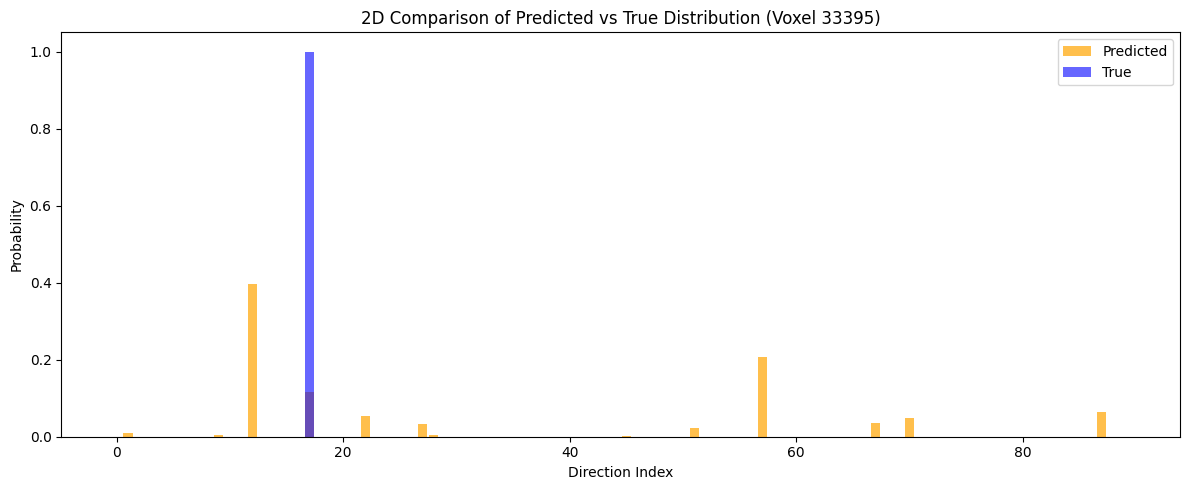

12
Error  Angle in radians: 0.1979948540330008
Error Angle in degrees: 11.344269501399731


In [158]:
##### import numpy as np
import matplotlib.pyplot as plt

# Load data
probs = np.load("output_probabilities.npy")      # shape: [N, 270]
#print(len())
# Choose voxel
voxel_idx = 33395
voxel_probs = probs[voxel_idx]  # [270]
true_label = labels[voxel_idx]  # scalar

# Reference one-hot distribution
ref_probs = np.zeros_like(voxel_probs)

ref_probs[true_label] = 1.0

# Plot 2D bar chart of predicted vs reference probabilities
plt.figure(figsize=(12, 5))
x = np.arange(len(voxel_probs))

plt.bar(x, voxel_probs, label="Predicted", alpha=0.7, color='orange')
plt.bar(x, ref_probs, label="True", alpha=0.6, color='blue')

plt.xlabel("Direction Index")
plt.ylabel("Probability")
plt.title(f"2D Comparison of Predicted vs True Distribution (Voxel {voxel_idx})")
plt.legend()
plt.tight_layout()
plt.savefig(f"voxel_{voxel_idx}_2d_prob_comparison.png")
plt.show()



voxel0_cuda = probs[voxel_idx]
voxel0_cpu = voxel0_cuda
voxel0_cpu_numpy = voxel0_cpu
#print(len(voxel0_cpu_numpy))
voxel0_maxdir = np.argmax(voxel0_cpu_numpy) #print(np.argmax(voxel_probs))
print(voxel0_maxdir)

angle_rad=calculate_angular_error(X[voxel_idx][voxel0_maxdir][2:], Y[voxel_idx])
angle_deg = np.degrees(angle_rad)

print(f"Error  Angle in radians: {angle_rad}")
print(f"Error Angle in degrees: {angle_deg}")

#print("true_label",true_label,probs[true_label])

In [131]:
voxel_idx

33395

In [132]:
print(voxel0_maxdir)

12


In [159]:
np.mean(pred_indices == labels)


0.5182057731464846

In [133]:
probs[31]

array([1.7288114e-06, 1.8965043e-11, 2.6953580e-11, 5.3565714e-06,
       4.7920121e-13, 3.3743492e-09, 9.7307600e-13, 4.0768390e-03,
       9.2163708e-07, 8.9573460e-11, 2.0321012e-10, 1.5550486e-02,
       1.7880068e-12, 1.5727316e-03, 1.1582313e-11, 2.5628141e-12,
       3.8469871e-06, 2.1234119e-12, 9.9577573e-09, 2.2596588e-11,
       4.4964192e-09, 3.1825142e-13, 1.9496937e-12, 2.0122869e-11,
       7.3031137e-13, 3.7281295e-10, 1.1517245e-06, 2.0834539e-12,
       3.8459925e-12, 1.0672569e-11, 3.2217046e-10, 3.1988821e-11,
       5.8076965e-10, 1.0541639e-06, 1.5578917e-07, 6.2580043e-01,
       9.2606159e-11, 1.0556565e-07, 1.1147869e-11, 1.4018289e-11,
       3.2204389e-10, 4.2722372e-09, 9.8486941e-13, 3.0389170e-11,
       5.6817520e-09, 5.7184497e-11, 3.8900367e-12, 9.3820221e-12,
       4.1837080e-07, 8.5889873e-09, 8.7725044e-12, 2.2081800e-12,
       1.9889596e-12, 1.2874551e-12, 3.4188101e-09, 3.8571285e-05,
       7.0616296e-10, 1.6718079e-12, 2.4672131e-11, 1.1071595e

In [134]:
Y[voxel_idx]

array([ 0.184153  ,  0.8028291 , -0.56705654], dtype=float32)

In [135]:
ref_probs.shape

(90,)

In [136]:
X[voxel_idx][voxel0_maxdir][2:]

array([ 0.1314509 ,  0.9044206 , -0.40588674], dtype=float32)

In [137]:
Y[voxel_idx]

array([ 0.184153  ,  0.8028291 , -0.56705654], dtype=float32)

In [138]:
len(probs)

33396

In [139]:
angular_errors_deg = []

for i in range(len(X)):
    # Get predicted direction index for this voxel
    pred_idx = np.argmax(prob_distributions[i])  # [270]

    # Extract predicted b-vector from input X
    pred_vec = X[i][pred_idx][2:]  # [bx, by, bz]

    # Get ground truth vector
    true_vec = Y[i]  # [x, y, z]

    # Compute angular error
    angle_rad = calculate_angular_error(pred_vec, true_vec)
    angle_deg = np.degrees(angle_rad)

    angular_errors_deg.append(angle_deg)

In [140]:
len(angular_errors_deg)

33396